# Ex10 - Texturas

Nesta atividade, vocês vão exercitar alguns dos conceitos de textura. Para evitar erros de execução, utilize apenas uma célula de código para cada parte desta atividade.

### Parte 1 - Skybox

Skybox é uma técnica de criação de background utilizada em jogos para simular o horizonte que rodeia o jogador. Resumidamente, esta técnica consiste em criar um cubo ao redor da cena criada. Nesse cubo, as faces internas são texturizadas com as imagens da paisagem que se deseja simular. Utilize uma das texturas presentes na pasta ./cg/images/textures/ para criar um skybox simples em torno de uma câmera posicionada no ponto (0,0,0). Além disso, utilize as teclas de seta para rotacionar o ponto de visão da câmera a fim de permitir visualizar o resultado da renderização do cubo. As imagens abaixo ilustram o efeito esperado ao rotacionar o ponto de visão da câmera. Os notebooks ([37_Renderizando_uma_textura_por_completo](37_Renderizando_uma_textura_por_completo.ipynb)) e ([38_Renderizando_parte_de_uma_textura](38_Renderizando_parte_de_uma_textura.ipynb)) exemplificam como utilizar texturas em renderizações. 

<table>
    <tr>
        <td> <img src='cg/images/ex10_image_1.png' style="width:400px"> </td>
        <td> <img src='cg/images/ex10_image_2.png' style="width:400px"></td>
        <td> <img src='cg/images/ex10_image_3.png' style="width:400px"></td>
    </tr>
</table>

In the following code we build a skybox, technique very much used in games to avoid unecessary 3D rendering:

In [22]:
import glm
import time
import numpy as np
import OpenGL.GL as gl
from PyQt5 import QtOpenGL, QtCore
from PyQt5.QtCore import QCoreApplication
from PyQt5.QtWidgets import QApplication

from cg.shader_programs.SimpleShaderProgram_v3 import SimpleShaderProgram
from cg.renderers.ModelRenderer_v4 import ModelRenderer
from cg.models.SquareMesh_v3 import SquareMesh
from cg.utils.Texture import Texture

class MyWidget(QtOpenGL.QGLWidget):
    def initializeGL(self):
        
        
        self.vwX=0.0 #camera X axis pointing direction
        self.vwY=0.0 #camera Y axis pointing direction
        self.vwZ=-1.0 #camera Z axis pointing direction
        
        self.theta = np.pi/2 #radians
        self.phi = 0.0 #radians
        
        self.cameraPos   = glm.vec3(0.0, 0.0, 0.0) #camera position
        self.cameraFront = glm.vec3(np.sqrt((self.vwX*self.vwX)+(self.vwY*self.vwY)+(self.vwZ*self.vwZ))*np.sin(self.theta)*np.sin(self.phi)
                                    , np.sqrt((self.vwX*self.vwX)+(self.vwY*self.vwY)+(self.vwZ*self.vwZ))*np.cos(self.theta)
                                    , np.sqrt((self.vwX*self.vwX)+(self.vwY*self.vwY)+(self.vwZ*self.vwZ))*np.sin(self.theta)*np.cos(self.phi)) #camera pointing direction
        self.cameraUp    = glm.vec3(0.0, 1.0, 0.0) #camera 'up' vector
    
        self.viewMatrix = glm.lookAt(self.cameraPos, self.cameraFront, self.cameraUp) #generate view matrix
        
        # square mesh vertices
        vertex_position = np.array([
            -0.50, -0.50, 0.0, 1.0, # Triangle 1
             0.50, -0.50, 0.0, 1.0,
            -0.50,  0.50, 0.0, 1.0,
             0.50, -0.50, 0.0, 1.0, # Triangle 2
             0.50,  0.50, 0.0, 1.0,
            -0.50,  0.50, 0.0, 1.0],
            dtype=np.float32)
        
        # define texture coordinates
        self.texCoord = np.array([
             0.00,  1.00, # Triangle 1
             1.00,  1.00,
             0.00,  0.00,
             1.00,  1.00, # Triangle 2
             1.00,  0.00,
             0.00,  0.00],
            dtype=np.float32)
        
        # calculate size of the texture frame
        # all loaded textures have same sized frames
        frame_size = np.array([1.0 / 4, 1.0 / 3], dtype=np.float32)
        self.texCoordFirstFrame = self.texCoord.reshape((6, 2)) * frame_size
        
        # calculate offset of all frames in relation to original frame
        x = np.linspace(0, 1, 5)
        y = np.linspace(0, 1, 4)
        self.frameOffset_x, self.frameOffset_y = np.meshgrid(x[:-1], y[:-1])
        
        self.frameOffset_x = self.frameOffset_x.reshape((12)).astype(np.float32)
        self.frameOffset_y = self.frameOffset_y.reshape((12)).astype(np.float32)
        
        # load the desired texture
        self.texture_1 = Texture('./cg/images/textures/skybox.png')
        
        # create object responsible for loading data onto GPU
        self.squareRenderer = ModelRenderer(vertex_position, vertex_tex=self.texCoord)
        
        # create simple shader
        self.shaderProgram = SimpleShaderProgram()
    
        # obtain input variable pointers
        position_loc = self.shaderProgram.getVertexPositionLoc()
        tex_coord_loc = self.shaderProgram.getVertexTextureCoordLoc()
        
        # set model data in shader program
        self.squareRenderer.setVertexPositionLoc(position_loc)
        self.squareRenderer.setVertexTextureCoordLoc(tex_coord_loc)
        
        # set background color
        gl.glClearColor(0.9, 0.9, 0.9, 1)
        
        # enable depth testing and culling
        gl.glEnable(gl.GL_DEPTH_TEST)
        gl.glEnable(gl.GL_CULL_FACE)
        
        
    def paintGL(self):
            
        # clean background with the specified color and depth buffer
        gl.glClear(gl.GL_COLOR_BUFFER_BIT | gl.GL_DEPTH_BUFFER_BIT)
        
        # activate shader program
        self.shaderProgram.bind()
        
        # render texturized squares
        self.renderTexture1()

        # deactivate shader program
        self.shaderProgram.release()
        
        # re-run paintGL method
        self.update()
    
    
    def renderTexture1(self):
        
        # enable blending
        gl.glEnable(gl.GL_BLEND)
        
        ######################################## RENDER MAIN FRAME ########################################
        
        # calculate transformation matrix and set MVP matrix        
        transl = glm.translate(glm.mat4(), glm.vec3(0.0, 0.0, -1.0))
        model_matrix = glm.scale(transl, glm.vec3(2.0, 2.0, 2.0))
        self.shaderProgram.setUniformMVPMatrix(self.perspectiveMatrix *self.viewMatrix*model_matrix)
        
        # configure and activate texture (and deactivate use of base color)
        self.shaderProgram.bindTexture2D(self.texture_1.getTextureID())
        
        # select correct frame (main frame)
        offset_x = self.frameOffset_x[5]
        offset_y = self.frameOffset_y[5]
        frame_tex = self.texCoordFirstFrame + np.array([offset_x, offset_y])
        
        # update gpu with desired frame's texture coordinates
        self.squareRenderer.updateVertexTextureCoord(frame_tex)
        
        # render frame
        self.squareRenderer.render()
        
        ######################################## RENDER TOP FRAME ########################################
        
        # calculate transformation matrix and set MVP matrix  (rotating plane around correct axis)       
        transl = glm.translate(glm.mat4(), glm.vec3(0.0, 1.0, 0.0))
        model_matrix = glm.rotate(transl, glm.radians(90.0), glm.vec3(1.0, 0.0, 0.0))
        model_matrix = glm.scale(model_matrix, glm.vec3(2.0, 2.0, 2.0))
        self.shaderProgram.setUniformMVPMatrix(self.perspectiveMatrix *self.viewMatrix*model_matrix)
        
        # configure and activate texture (and deactivate use of base color)
        self.shaderProgram.bindTexture2D(self.texture_1.getTextureID())
        
        # select correct frame (top frame)
        offset_x = self.frameOffset_x[1]
        offset_y = self.frameOffset_y[1]
        frame_tex = self.texCoordFirstFrame + np.array([offset_x, offset_y])
        
        # update gpu with desired frame's texture coordinates
        self.squareRenderer.updateVertexTextureCoord(frame_tex)
        
        # render frame
        self.squareRenderer.render()
        
        ######################################## RENDER BOTTOM FRAME ########################################
        
        # calculate transformation matrix and set MVP matrix  (rotating plane around correct axis)         
        transl = glm.translate(glm.mat4(), glm.vec3(0.0, -1.0, 0.0))
        model_matrix = glm.rotate(transl, glm.radians(-90.0), glm.vec3(1.0, 0.0, 0.0))
        model_matrix = glm.scale(model_matrix, glm.vec3(2.0, 2.0, 2.0))
        self.shaderProgram.setUniformMVPMatrix(self.perspectiveMatrix *self.viewMatrix*model_matrix)
        
        # configure and activate texture (and deactivate use of base color)
        self.shaderProgram.bindTexture2D(self.texture_1.getTextureID())
        
        # select correct frame (bottom frame)
        offset_x = self.frameOffset_x[9]
        offset_y = self.frameOffset_y[9]
        frame_tex = self.texCoordFirstFrame + np.array([offset_x, offset_y])
        
        # update gpu with desired frame's texture coordinates
        self.squareRenderer.updateVertexTextureCoord(frame_tex)
        
        # render frame
        self.squareRenderer.render()
        
        ######################################## RENDER LEFT FRAME ########################################
        
        # calculate transformation matrix and set MVP matrix  (rotating plane around correct axis)           
        transl = glm.translate(glm.mat4(), glm.vec3(-1.0, 0.0, 0.0))
        model_matrix = glm.rotate(transl, glm.radians(90.0), glm.vec3(0.0, 1.0, 0.0))
        model_matrix = glm.scale(model_matrix, glm.vec3(2.0, 2.0, 2.0))
        self.shaderProgram.setUniformMVPMatrix(self.perspectiveMatrix *self.viewMatrix*model_matrix)
        
        # configure and activate texture (and deactivate use of base color)
        self.shaderProgram.bindTexture2D(self.texture_1.getTextureID())
        
        #select correct frame (left frame)
        offset_x = self.frameOffset_x[4]
        offset_y = self.frameOffset_y[4]
        frame_tex = self.texCoordFirstFrame + np.array([offset_x, offset_y])
        
        # update gpu with desired frame's texture coordinates
        self.squareRenderer.updateVertexTextureCoord(frame_tex)
        
        # render frame
        self.squareRenderer.render()
        
        ######################################## RENDER RIGHT FRAME ########################################
        
        # calculate transformation matrix and set MVP matrix  (rotating plane around correct axis)          
        transl = glm.translate(glm.mat4(), glm.vec3(1.0, 0.0, 0.0))
        model_matrix = glm.rotate(transl, glm.radians(-90.0), glm.vec3(0.0, 1.0, 0.0))
        model_matrix = glm.scale(model_matrix, glm.vec3(2.0, 2.0, 2.0))
        self.shaderProgram.setUniformMVPMatrix(self.perspectiveMatrix *self.viewMatrix*model_matrix)
        
        # configure and activate texture (and deactivate use of base color)
        self.shaderProgram.bindTexture2D(self.texture_1.getTextureID())
        
        # select correct frame (right frame)
        offset_x = self.frameOffset_x[6]
        offset_y = self.frameOffset_y[6]
        frame_tex = self.texCoordFirstFrame + np.array([offset_x, offset_y])
        
        # update gpu with desired frame's texture coordinates
        self.squareRenderer.updateVertexTextureCoord(frame_tex)
        
        # render frame
        self.squareRenderer.render()
        
        ######################################## RENDER BACK FRAME ########################################
        
        # calculate transformation matrix and set MVP matrix  (rotating plane around correct axis)          
        transl = glm.translate(glm.mat4(), glm.vec3(0.0, 0.0, 1.0))
        model_matrix = glm.rotate(transl, glm.radians(-180.0), glm.vec3(0.0, 1.0, 0.0))
        model_matrix = glm.scale(model_matrix, glm.vec3(2.0, 2.0, 2.0))
        self.shaderProgram.setUniformMVPMatrix(self.perspectiveMatrix *self.viewMatrix*model_matrix)
        
        # configure and activate texture (and deactivate use of base color)
        self.shaderProgram.bindTexture2D(self.texture_1.getTextureID())
        
        # select correct frame (back frame)
        offset_x = self.frameOffset_x[7]
        offset_y = self.frameOffset_y[7]
        frame_tex = self.texCoordFirstFrame + np.array([offset_x, offset_y])
        
        # update gpu with desired frame's texture coordinates
        self.squareRenderer.updateVertexTextureCoord(frame_tex)
        
        # render frame
        self.squareRenderer.render()
        
        # deactivate texture
        self.shaderProgram.releaseTexture2D()
        
        # deactivate blending
        gl.glDisable(gl.GL_BLEND)


    def resizeGL(self, width, height):
        gl.glViewport(0, 0, width, height)
        
        # set projection matrix
        aspectRatio = width / height
        self.perspectiveMatrix = glm.perspective(glm.radians(60.0), aspectRatio, 0.1, 50.0)

        
    def keyPressEvent(self, event):
        super(MyWidget, self).keyPressEvent(event)
        
        thetaStep = np.pi/20 
        phiStep = np.pi/20 
        
        if event.key() == QtCore.Qt.Key_Up:
            self.theta -= thetaStep # rotate negatively in theta
        elif event.key() == QtCore.Qt.Key_Down:
            self.theta += thetaStep # rotate positively in theta
        elif event.key() == QtCore.Qt.Key_Right:
            self.phi -= phiStep # rotate negatively in phi
        elif event.key() == QtCore.Qt.Key_Left:
            self.phi += phiStep # rotate positively in phi
        
        # update camera cartesian coordinates via spheric-cartesian conversion
        self.vwX = np.sqrt((self.vwX*self.vwX)+(self.vwY*self.vwY)+(self.vwZ*self.vwZ))*np.sin(self.theta)*np.sin(self.phi)
        self.vwZ = np.sqrt((self.vwX*self.vwX)+(self.vwY*self.vwY)+(self.vwZ*self.vwZ))*np.sin(self.theta)*np.cos(self.phi)    
        self.vwY = np.sqrt((self.vwX*self.vwX)+(self.vwY*self.vwY)+(self.vwZ*self.vwZ))*np.cos(self.theta)
        
        self.cameraFront = glm.vec3(self.vwX, self.vwY, self.vwZ) #set camera pointing direction
        self.viewMatrix = glm.lookAt(self.cameraPos, self.cameraFront, self.cameraUp) #update view matrix
       
    
def main():
    import sys

    #Create Qt application
    app = QCoreApplication.instance()
    if app is None:
        app = QApplication(sys.argv)

    #Specify openGL context
    glformat = QtOpenGL.QGLFormat()
    glformat.setVersion(3, 3)
    glformat.setDoubleBuffer(True)
    glformat.setProfile(QtOpenGL.QGLFormat.CoreProfile)
    
    #create rendering window
    w = MyWidget(glformat)
    w.resize(900, 800)
    w.setWindowTitle('OpenGL example')
    w.show()
    
    sys.exit(app.exec_())

if __name__ == '__main__':
    main()


trying to open ./cg/images/textures/skybox.png
opened file: size= (1024, 768) format= PNG mode= RGBA


SystemExit: 0

As you can see in the following animation, the code above succesfully generates a skybox: 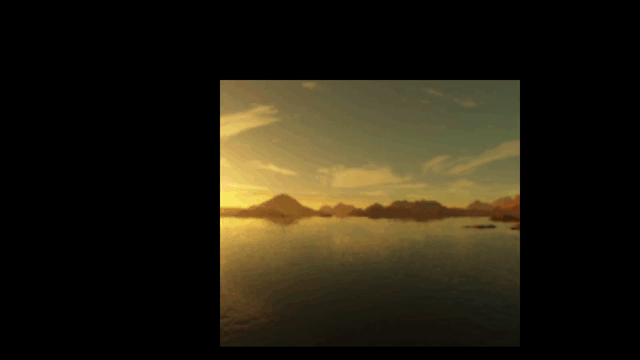

A few problems were encountered while developing the above code: 

<ul><li>Setting up the correct camera rotation control: remember that to fully rotate our camera, we must use the spheric coordinate system. This lead us to encounter another subtle problem with the camera. Here, we must remember that the skybox is set-up with the y-axis representing "height". This means that theta is the angle with the y-axis (not the z-axis) and that phi rotates on the x-z plane (not the x-y plane). Consequently, we had to interchange correctly the common r,theta,phi to x,y,z equations.</ul></li>

<ul><li>Setting up the skybox frames. The important thing to remember here is that for each skybox frame to be correctly viewed, it must be rotated the correct amount around the correct axis. For this to be easier, remember in what plane the frames are originaly placed when loaded.</ul></li>

### Parte 2 - Objetos texturizados

Adicione à renderização da Parte 1 pelo menos dois objetos texturizados ([41_Objetos_com_texturas_e_height_maps](41_Objetos_com_texturas_e_height_maps.ipynb) e [40_Objetos_com_texturas](40_Objetos_com_texturas.ipynb)) e uma fonte de luz direcional ([34_Terreno_com_esferas_iluminacao_fonte_de_luz_direcional](34_Terreno_com_esferas_iluminacao_fonte_de_luz_direcional.ipynb)) para simular o sol. A pasta ./cg/images/textures/ possui algumas texturas que podem ser utilizadas nos objetos.

In the code below, we add to texturized spheres and a light source to the skybox developed above:

In [23]:
import glm
import time
import numpy as np
import OpenGL.GL as gl
from PyQt5 import QtOpenGL, QtCore
from PyQt5.QtCore import QCoreApplication
from PyQt5.QtWidgets import QApplication

from cg.shader_programs.PhongShadingShaderProgram_v2 import PhongShadingShaderProgram
from cg.shader_programs.SimpleShaderProgram_v3 import SimpleShaderProgram
from cg.renderers.ModelRenderer_v4 import ModelRenderer
from cg.models.SquareMesh_v3 import SquareMesh
from cg.models.SphereMesh_v3 import SphereMesh
from cg.utils.Texture import Texture

class MyWidget(QtOpenGL.QGLWidget):
    def initializeGL(self):
        
        
        self.vwX=0.0 #camera X axis pointing direction
        self.vwY=0.0 #camera Y axis pointing direction
        self.vwZ=-1.0 #camera Z axis pointing direction
        
        self.theta = np.pi/2 #initial camera theta rotation in radians
        self.phi = 0.0 # initial camera phi rotation in radians
        
        self.lightPosition = glm.vec4(0.99, 0.1, 0.99, 1) # set light position
        
        self.cameraPos   = glm.vec3(0.0, 0.0, 0.0) #camera position
        self.cameraFront = glm.vec3(np.sqrt((self.vwX*self.vwX)+(self.vwY*self.vwY)+(self.vwZ*self.vwZ))*np.sin(self.theta)*np.sin(self.phi)
                                    , np.sqrt((self.vwX*self.vwX)+(self.vwY*self.vwY)+(self.vwZ*self.vwZ))*np.cos(self.theta)
                                    , np.sqrt((self.vwX*self.vwX)+(self.vwY*self.vwY)+(self.vwZ*self.vwZ))*np.sin(self.theta)*np.cos(self.phi)) #camera pointing direction
        self.cameraUp    = glm.vec3(0.0, 1.0, 0.0) #camera 'up' vector
    
        self.viewMatrix = glm.lookAt(self.cameraPos, self.cameraFront, self.cameraUp) #generate view matrix
        
        # square mesh vertices
        vertex_position = np.array([
            -0.50, -0.50, 0.0, 1.0, # Triangle 1
             0.50, -0.50, 0.0, 1.0,
            -0.50,  0.50, 0.0, 1.0,
             0.50, -0.50, 0.0, 1.0, # Triangle 2
             0.50,  0.50, 0.0, 1.0,
            -0.50,  0.50, 0.0, 1.0],
            dtype=np.float32)
        
        # define texture coordinates
        self.texCoord = np.array([
             0.00,  1.00, # Triangle 1
             1.00,  1.00,
             0.00,  0.00,
             1.00,  1.00, # Triangle 2
             1.00,  0.00,
             0.00,  0.00],
            dtype=np.float32)
        
         # cria as malha
        sphere_mesh = SphereMesh(0.4, 200, 200)
        
        # create object responsable for loading data onto GPU and rendering
        self.phongSphereRenderer = ModelRenderer(sphere_mesh.getVertexPositions(),
                                             vertex_indices=sphere_mesh.getVertexIndices(),
                                             vertex_normal=sphere_mesh.getVertexNormals(),
                                                 vertex_tex=sphere_mesh.getVertexTextureCoord())
        
        # calculate size of the texture frame
        # all loaded textures have same sized frames
        frame_size = np.array([1.0 / 4, 1.0 / 3], dtype=np.float32)
        self.texCoordFirstFrame = self.texCoord.reshape((6, 2)) * frame_size
        
        # calculate offset of all frames in relation to original frame
        x = np.linspace(0, 1, 5)
        y = np.linspace(0, 1, 4)
        self.frameOffset_x, self.frameOffset_y = np.meshgrid(x[:-1], y[:-1])
        
        self.frameOffset_x = self.frameOffset_x.reshape((12)).astype(np.float32)
        self.frameOffset_y = self.frameOffset_y.reshape((12)).astype(np.float32)
        
        # load the desired textures
        self.texture_1 = Texture('./cg/images/textures/skybox.png') #skybox
        self.textureObject1 = Texture('./cg/images/textures/Colored_Pencils_001_SD/Colored_Pencils_001_basecolor.jpg') #sphere1
        self.textureObject2 = Texture('./cg/images/textures/Metal_Sci-fi_003_SD/Metal_Sci-fi_003_basecolor.jpg') #sphere2
        
        # create object responsible for loading data onto GPU
        self.squareRenderer = ModelRenderer(vertex_position, vertex_tex=self.texCoord)
        
        # create Phong ilumination shader for all objects except light       
        # point light is the default source type
        self.phongShaderProgram = PhongShadingShaderProgram()
        
        # create simple shader
        self.shaderProgram = SimpleShaderProgram()
        
        # configure phong shader
        self.phongShaderProgram.bind()
        self.phongShaderProgram.setUniformLightPosition(self.viewMatrix * self.lightPosition) #a posição da luz tem que estar no espaço de visão
        self.phongShaderProgram.release()
        
        # obtain inputs variable pointers and set model data as inputs for the phong shader
        position_loc = self.phongShaderProgram.getVertexPositionLoc()
        normal_loc = self.phongShaderProgram.getVertexNormalLoc()
        tex_coord_loc = self.phongShaderProgram.getVertexTextureCoordLoc()
        self.phongSphereRenderer.setVertexPositionLoc(position_loc)
        self.phongSphereRenderer.setVertexNormalLoc(normal_loc)
        self.phongSphereRenderer.setVertexTextureCoordLoc(tex_coord_loc)
    
        # obtain input variable pointers and set model data as inputs in shader program
        position_loc = self.shaderProgram.getVertexPositionLoc()
        tex_coord_loc = self.shaderProgram.getVertexTextureCoordLoc()
        self.squareRenderer.setVertexPositionLoc(position_loc)
        self.squareRenderer.setVertexTextureCoordLoc(tex_coord_loc)
        
        # set background color
        gl.glClearColor(0.9, 0.9, 0.9, 1)
        
        # enable depth testing and culling
        gl.glEnable(gl.GL_DEPTH_TEST)
        gl.glEnable(gl.GL_CULL_FACE)
        
        # initialize rotation angle variable for rotating spheres
        self.angle = 0.0
        
        
    def paintGL(self):
        
        # increment sphere rotation angle variable
        self.angle += 0.1
        
        # clean background with the specified color and depth buffer
        gl.glClear(gl.GL_COLOR_BUFFER_BIT | gl.GL_DEPTH_BUFFER_BIT)
        
        # activate shader program
        self.shaderProgram.bind()
        # render texturized squares
        self.renderTexture1()
        # deactivate shader program
        self.shaderProgram.release()
        
        # activate phong shader
        self.phongShaderProgram.bind()
        # render texturized objects
        self.renderObject1()
        self.renderObject2()
        # deactivate phong shader
        self.phongShaderProgram.release()
        
        # re-run paintGL method
        self.update()
    
    
    
    def renderObject1(self):
        
        # calculate transfomration matrices and set shaderMVP matrix
        transl = glm.translate(glm.mat4(), glm.vec3(-0.6, 0.1, 0.0))
        model_matrix = glm.rotate(transl, glm.radians(-self.angle), glm.vec3(0.0, 1.0, 0.0))
        model_matrix = glm.scale(model_matrix, glm.vec3(0.05, 0.05, 0.05))
        self.phongShaderProgram.setUniformMVPMatrix(self.perspectiveMatrix * self.viewMatrix * model_matrix)
        
        # set model-view matrix for ilumination
        self.phongShaderProgram.setUniformModelViewMatrix(self.viewMatrix * model_matrix)
        
        # set texture to be used
        self.phongShaderProgram.bindTexture2D(self.textureObject1.getTextureID())
        
        # render object
        self.phongSphereRenderer.render()
        
        # deactivate texture
        self.phongShaderProgram.releaseTexture2D()
     
    
    
    def renderObject2(self):
        
        # calculate transfomration matrices and set shaderMVP matrix
        transl = glm.translate(glm.mat4(), glm.vec3(0.6, 0.05, -0.5))
        model_matrix = glm.rotate(transl, glm.radians(-self.angle), glm.vec3(0.0, 1.0, 0.0))
        model_matrix = glm.scale(model_matrix, glm.vec3(0.15, 0.15, 0.15))
        self.phongShaderProgram.setUniformMVPMatrix(self.perspectiveMatrix * self.viewMatrix * model_matrix)
        
        # set model-view matrix for ilumination
        self.phongShaderProgram.setUniformModelViewMatrix(self.viewMatrix * model_matrix)
        
        # set texture to be used
        self.phongShaderProgram.bindTexture2D(self.textureObject2.getTextureID())
        
        # render object
        self.phongSphereRenderer.render()
        
        # deactivate texture
        self.phongShaderProgram.releaseTexture2D()
    
    
    
    def renderTexture1(self):
        
        # enable blending
        gl.glEnable(gl.GL_BLEND)
        
        ######################################## RENDER MAIN FRAME ########################################
        
        # calculate transformation matrix and set MVP matrix        
        transl = glm.translate(glm.mat4(), glm.vec3(0.0, 0.0, -1.0))
        model_matrix = glm.scale(transl, glm.vec3(2.0, 2.0, 2.0))
        self.shaderProgram.setUniformMVPMatrix(self.perspectiveMatrix *self.viewMatrix*model_matrix)
        
        # configure and activate texture (and deactivate use of base color)
        self.shaderProgram.bindTexture2D(self.texture_1.getTextureID())
        
        # select correct frame (main frame)
        offset_x = self.frameOffset_x[5]
        offset_y = self.frameOffset_y[5]
        frame_tex = self.texCoordFirstFrame + np.array([offset_x, offset_y])
        
        # update gpu with desired frame's texture coordinates
        self.squareRenderer.updateVertexTextureCoord(frame_tex)
        
        # render frame
        self.squareRenderer.render()
        
        ######################################## RENDER TOP FRAME ########################################
        
        # calculate transformation matrix and set MVP matrix  (rotating plane around correct axis)       
        transl = glm.translate(glm.mat4(), glm.vec3(0.0, 1.0, 0.0))
        model_matrix = glm.rotate(transl, glm.radians(90.0), glm.vec3(1.0, 0.0, 0.0))
        model_matrix = glm.scale(model_matrix, glm.vec3(2.0, 2.0, 2.0))
        self.shaderProgram.setUniformMVPMatrix(self.perspectiveMatrix *self.viewMatrix*model_matrix)
        
        # configure and activate texture (and deactivate use of base color)
        self.shaderProgram.bindTexture2D(self.texture_1.getTextureID())
        
        # select correct frame (top frame)
        offset_x = self.frameOffset_x[1]
        offset_y = self.frameOffset_y[1]
        frame_tex = self.texCoordFirstFrame + np.array([offset_x, offset_y])
        
        # update gpu with desired frame's texture coordinates
        self.squareRenderer.updateVertexTextureCoord(frame_tex)
        
        # render frame
        self.squareRenderer.render()
        
        ######################################## RENDER BOTTOM FRAME ########################################
        
        # calculate transformation matrix and set MVP matrix  (rotating plane around correct axis)         
        transl = glm.translate(glm.mat4(), glm.vec3(0.0, -1.0, 0.0))
        model_matrix = glm.rotate(transl, glm.radians(-90.0), glm.vec3(1.0, 0.0, 0.0))
        model_matrix = glm.scale(model_matrix, glm.vec3(2.0, 2.0, 2.0))
        self.shaderProgram.setUniformMVPMatrix(self.perspectiveMatrix *self.viewMatrix*model_matrix)
        
        # configure and activate texture (and deactivate use of base color)
        self.shaderProgram.bindTexture2D(self.texture_1.getTextureID())
        
        # select correct frame (bottom frame)
        offset_x = self.frameOffset_x[9]
        offset_y = self.frameOffset_y[9]
        frame_tex = self.texCoordFirstFrame + np.array([offset_x, offset_y])
        
        # update gpu with desired frame's texture coordinates
        self.squareRenderer.updateVertexTextureCoord(frame_tex)
        
        # render frame
        self.squareRenderer.render()
        
        ######################################## RENDER LEFT FRAME ########################################
        
        # calculate transformation matrix and set MVP matrix  (rotating plane around correct axis)           
        transl = glm.translate(glm.mat4(), glm.vec3(-1.0, 0.0, 0.0))
        model_matrix = glm.rotate(transl, glm.radians(90.0), glm.vec3(0.0, 1.0, 0.0))
        model_matrix = glm.scale(model_matrix, glm.vec3(2.0, 2.0, 2.0))
        self.shaderProgram.setUniformMVPMatrix(self.perspectiveMatrix *self.viewMatrix*model_matrix)
        
        # configure and activate texture (and deactivate use of base color)
        self.shaderProgram.bindTexture2D(self.texture_1.getTextureID())
        
        #select correct frame (left frame)
        offset_x = self.frameOffset_x[4]
        offset_y = self.frameOffset_y[4]
        frame_tex = self.texCoordFirstFrame + np.array([offset_x, offset_y])
        
        # update gpu with desired frame's texture coordinates
        self.squareRenderer.updateVertexTextureCoord(frame_tex)
        
        # render frame
        self.squareRenderer.render()
        
        ######################################## RENDER RIGHT FRAME ########################################
        
        # calculate transformation matrix and set MVP matrix  (rotating plane around correct axis)          
        transl = glm.translate(glm.mat4(), glm.vec3(1.0, 0.0, 0.0))
        model_matrix = glm.rotate(transl, glm.radians(-90.0), glm.vec3(0.0, 1.0, 0.0))
        model_matrix = glm.scale(model_matrix, glm.vec3(2.0, 2.0, 2.0))
        self.shaderProgram.setUniformMVPMatrix(self.perspectiveMatrix *self.viewMatrix*model_matrix)
        
        # configure and activate texture (and deactivate use of base color)
        self.shaderProgram.bindTexture2D(self.texture_1.getTextureID())
        
        # select correct frame (right frame)
        offset_x = self.frameOffset_x[6]
        offset_y = self.frameOffset_y[6]
        frame_tex = self.texCoordFirstFrame + np.array([offset_x, offset_y])
        
        # update gpu with desired frame's texture coordinates
        self.squareRenderer.updateVertexTextureCoord(frame_tex)
        
        # render frame
        self.squareRenderer.render()
        
        ######################################## RENDER BACK FRAME ########################################
        
        # calculate transformation matrix and set MVP matrix  (rotating plane around correct axis)          
        transl = glm.translate(glm.mat4(), glm.vec3(0.0, 0.0, 1.0))
        model_matrix = glm.rotate(transl, glm.radians(-180.0), glm.vec3(0.0, 1.0, 0.0))
        model_matrix = glm.scale(model_matrix, glm.vec3(2.0, 2.0, 2.0))
        self.shaderProgram.setUniformMVPMatrix(self.perspectiveMatrix *self.viewMatrix*model_matrix)
        
        # configure and activate texture (and deactivate use of base color)
        self.shaderProgram.bindTexture2D(self.texture_1.getTextureID())
        
        # select correct frame (back frame)
        offset_x = self.frameOffset_x[7]
        offset_y = self.frameOffset_y[7]
        frame_tex = self.texCoordFirstFrame + np.array([offset_x, offset_y])
        
        # update gpu with desired frame's texture coordinates
        self.squareRenderer.updateVertexTextureCoord(frame_tex)
        
        # render frame
        self.squareRenderer.render()
        
        # deactivate texture
        self.shaderProgram.releaseTexture2D()
        
        # deactivate blending
        gl.glDisable(gl.GL_BLEND)


    def resizeGL(self, width, height):
        gl.glViewport(0, 0, width, height)
        
        # set projection matrix
        aspectRatio = width / height
        self.perspectiveMatrix = glm.perspective(glm.radians(60.0), aspectRatio, 0.1, 50.0)

        
    def keyPressEvent(self, event):
        super(MyWidget, self).keyPressEvent(event)
        
        thetaStep = np.pi/20 
        phiStep = np.pi/20 
        
        if event.key() == QtCore.Qt.Key_Up:
            self.theta -= thetaStep # rotate negatively in theta
        elif event.key() == QtCore.Qt.Key_Down:
            self.theta += thetaStep # rotate positively in theta
        elif event.key() == QtCore.Qt.Key_Right:
            self.phi -= phiStep # rotate negatively in phi
        elif event.key() == QtCore.Qt.Key_Left:
            self.phi += phiStep # rotate positively in phi
        
        # update camera cartesian coordinates via spheric-cartesian conversion
        self.vwX = np.sqrt((self.vwX*self.vwX)+(self.vwY*self.vwY)+(self.vwZ*self.vwZ))*np.sin(self.theta)*np.sin(self.phi)
        self.vwZ = np.sqrt((self.vwX*self.vwX)+(self.vwY*self.vwY)+(self.vwZ*self.vwZ))*np.sin(self.theta)*np.cos(self.phi)    
        self.vwY = np.sqrt((self.vwX*self.vwX)+(self.vwY*self.vwY)+(self.vwZ*self.vwZ))*np.cos(self.theta)    
        
        self.cameraFront = glm.vec3(self.vwX, self.vwY, self.vwZ) #set camera pointing direction
        self.viewMatrix = glm.lookAt(self.cameraPos, self.cameraFront, self.cameraUp) #update view matrix
       
    
def main():
    import sys

    #Create Qt application
    app = QCoreApplication.instance()
    if app is None:
        app = QApplication(sys.argv)

    #Specify openGL context
    glformat = QtOpenGL.QGLFormat()
    glformat.setVersion(3, 3)
    glformat.setDoubleBuffer(True)
    glformat.setProfile(QtOpenGL.QGLFormat.CoreProfile)
    
    #create rendering window
    w = MyWidget(glformat)
    w.resize(900, 800)
    w.setWindowTitle('OpenGL example')
    w.show()
    
    sys.exit(app.exec_())

if __name__ == '__main__':
    main()


trying to open ./cg/images/textures/skybox.png
opened file: size= (1024, 768) format= PNG mode= RGBA
trying to open ./cg/images/textures/Colored_Pencils_001_SD/Colored_Pencils_001_basecolor.jpg
opened file: size= (1024, 1024) format= JPEG mode= RGB
trying to open ./cg/images/textures/Metal_Sci-fi_003_SD/Metal_Sci-fi_003_basecolor.jpg
opened file: size= (1024, 1024) format= JPEG mode= RGB


SystemExit: 0

As we can se in the following animation, the code above succesfully adds the light source and texturized spheres to the original skybox: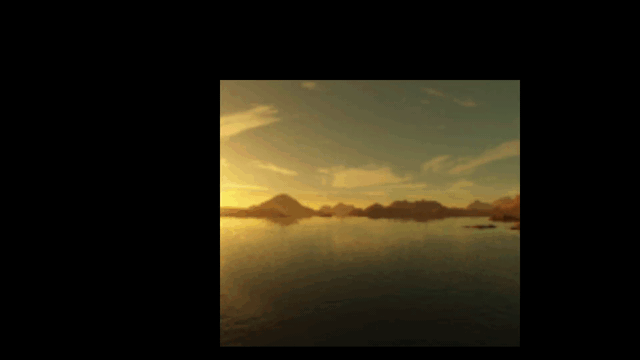
The only problems encountered here were minor coding errors: besides them, the implementation was very direct.

### Parte 3 - Sprites animados

Em alguns games 2D, a animação de sprites é utilizada no lugar de objetos em movimento compostos por malha de triângulos. O notebook [39_Renderizando_sprites_animados](39_Renderizando_sprites_animados.ipynb) exemplifica essa técnica. Utilize uma das texturas de sprites presentes na pasta ./cg/images/textures/ para montar pelo menos duas animações que são disparadas por eventos de teclado. Por exemplo, se a tecla de seta 'para direita' for pressionada, a animação do sprite andando para direita começa.

In the code below, we load sprites and add key control to trigger them:

In [24]:
import glm
import time
import numpy as np
import OpenGL.GL as gl
from PyQt5 import QtOpenGL
from PyQt5.QtCore import QCoreApplication
from PyQt5.QtWidgets import QApplication

from cg.shader_programs.SimpleShaderProgram_v3 import SimpleShaderProgram
from cg.renderers.ModelRenderer_v4 import ModelRenderer
from cg.models.SquareMesh_v3 import SquareMesh
from cg.utils.Texture import Texture

class MyWidget(QtOpenGL.QGLWidget):
    def initializeGL(self):
        
        self.cameraPos   = glm.vec3(0.0, 0.0, 1.2)
        self.cameraFront = glm.vec3(0.0, 0.0, 0.0)
        self.cameraUp    = glm.vec3(0.0, 1.0,  0.0)
        
        self.explosion = False
        self.fire = False
    
        self.viewMatrix = glm.lookAt(self.cameraPos, self.cameraFront, self.cameraUp)
        
        # define square mesh
        vertex_position = np.array([
            -0.50, -0.50, 0.0, 1.0, # Triângulo 1
             0.50, -0.50, 0.0, 1.0,
            -0.50,  0.50, 0.0, 1.0,
             0.50, -0.50, 0.0, 1.0, # Triângulo 2
             0.50,  0.50, 0.0, 1.0,
            -0.50,  0.50, 0.0, 1.0],
            dtype=np.float32)
        
        # define texture coordinates
        self.texCoord = np.array([
             0.00,  1.00, # Triangle 1
             1.00,  1.00,
             0.00,  0.00,
             1.00,  1.00, # Triangle 2
             1.00,  0.00,
             0.00,  0.00],
            dtype=np.float32)
        
        
        
        #################################### EXPLOSION SPRITE DATA ####################################
        
        # calculate size of the texture frame
        explosion_frame_size = np.array([1.0 / 8, 1.0 / 6], dtype=np.float32)
        self.explosionTexCoordFirstFrame = self.texCoord.reshape((6, 2)) * explosion_frame_size
        
        # calculate offset of all frames in relation to original frame
        x = np.linspace(0, 1, 9)
        y = np.linspace(0, 1, 7)
        self.explosionFrameOffset_x, self.explosionFrameOffset_y = np.meshgrid(x[:-1], y[:-1])
        self.explosionFrameOffset_x = self.explosionFrameOffset_x.reshape((48)).astype(np.float32)
        self.explosionFrameOffset_y = self.explosionFrameOffset_y.reshape((48)).astype(np.float32)
        
        # define animation sequence
        self.explosionFrameSeq = np.arange(0, 48)
        self.explosionTexCoordCurrentFrame = self.explosionTexCoordFirstFrame
        self.explosionCurrentFrameIndex = 0
        
        
        #################################### FIRE SPRITE DATA ####################################
        
        # calculate size of the texture frame
        fire_frame_size = np.array([1.0 / 10, 1.0 / 6], dtype=np.float32)
        self.fireTexCoordFirstFrame = (self.texCoord.reshape((6, 2)) * fire_frame_size)
        
        # calculate offset of all frames in relation to original frame
        x = np.linspace(0, 1, 11)
        y = np.linspace(0, 1, 7)
        self.fireFrameOffset_x, self.fireFrameOffset_y = np.meshgrid(x[:-1], y[:-1])
        
        self.fireFrameOffset_x = self.fireFrameOffset_x.reshape((60)).astype(np.float32)
        self.fireFrameOffset_y = self.fireFrameOffset_y.reshape((60)).astype(np.float32)
        
        # define animation sequence
        self.fireFrameSeq = np.arange(0, 60)
        self.fireTexCoordCurrentFrame = self.fireTexCoordFirstFrame
        self.fireCurrentFrameIndex = 0
        
        ##########################################################################################
        
        # load the desired textures
        self.texture_3 = Texture('./cg/images/textures/explosion_pngfuel.com.png')
        self.texture_4 = Texture('./cg/images/textures/fire_opengameart.org.png')
        
        # create object responsible for loading data onto GPU and rendering
        self.squareRenderer = ModelRenderer(vertex_position, vertex_tex=self.texCoord)
        
        # create simple shader program
        self.shaderProgram = SimpleShaderProgram()

        # obtain input variable pointers and set model data as inputs in shader program
        position_loc = self.shaderProgram.getVertexPositionLoc()
        tex_coord_loc = self.shaderProgram.getVertexTextureCoordLoc()
        self.squareRenderer.setVertexPositionLoc(position_loc)
        self.squareRenderer.setVertexTextureCoordLoc(tex_coord_loc)
        
        # set background color
        gl.glClearColor(0.9, 0.9, 0.9, 1)
        
        # store program start time
        self.startTime = time.time()
        
        # enable depth testing and culling
        gl.glEnable(gl.GL_DEPTH_TEST);
        gl.glEnable(gl.GL_CULL_FACE)
        
        #configure blending function
        gl.glBlendFunc(gl.GL_SRC_ALPHA, gl.GL_ONE_MINUS_SRC_ALPHA)
        
    def paintGL(self):
            
        # clean background with the specified color and depth buffer
        gl.glClear(gl.GL_COLOR_BUFFER_BIT | gl.GL_DEPTH_BUFFER_BIT)
        
        # activate shader program
        self.shaderProgram.bind()
        
        # update sprite frames
        self.updateFrames()
        
        # render frames
        self.renderExplosion()
        self.renderFire()
        
        # deactivate shader program
        self.shaderProgram.release()
        
        # re-run paintGL method
        self.update()
    
    def updateFrames(self):
        
        # calculate the current run time
        self.currentTime = time.time()
        time_difference = self.currentTime - self.startTime
        
        if(time_difference > 0.05):
            self.startTime = self.currentTime
            time_difference = 0

            # if the explosion trigger has been pressed (up arrow key)
            if self.explosion == True:
                self.explosionCurrentFrameIndex += 1
                if(self.explosionCurrentFrameIndex >= self.explosionFrameSeq.size):
                    self.explosionCurrentFrameIndex = 0
                    self.explosion = False # stop animation (explosion must be re-triggered)
                if self.explosion == True:
                    offset_x = self.explosionFrameOffset_x[self.explosionFrameSeq[self.explosionCurrentFrameIndex]]
                    offset_y = self.explosionFrameOffset_y[self.explosionFrameSeq[self.explosionCurrentFrameIndex]]
                    self.explosionTexCoordCurrentFrame = self.explosionTexCoordFirstFrame + np.array([offset_x, offset_y])
            
            # if the fire starter has been pressed (down arrow key)
            if self.fire == True:
                self.fireCurrentFrameIndex += 1
                if(self.fireCurrentFrameIndex >= self.fireFrameSeq.size):
                    self.fireCurrentFrameIndex = 0 #restart antimation from the beginning automatically  
                offset_x = self.fireFrameOffset_x[self.fireFrameSeq[self.fireCurrentFrameIndex]]
                offset_y = self.fireFrameOffset_y[self.fireFrameSeq[self.fireCurrentFrameIndex]]
                self.fireTexCoordCurrentFrame = self.fireTexCoordFirstFrame + np.array([offset_x, offset_y])

     
    
    def keyPressEvent(self, event):
        super(MyWidget, self).keyPressEvent(event)
        
        if event.key() == QtCore.Qt.Key_Up:
            self.explosion = True
        elif event.key() == QtCore.Qt.Key_Down:
            self.fire = True

    
    def renderExplosion(self):
        
        # set and activate texture
        self.shaderProgram.bindTexture2D(self.texture_3.getTextureID())
        
        # update texture coordinates
        self.squareRenderer.updateVertexTextureCoord(self.texCoord)
    
        # enable blending
        gl.glEnable(gl.GL_BLEND)
        
        # calculate transformation matrices and set MVP matrix
        model_matrix = glm.translate(glm.mat4(), glm.vec3(-0.8, 0.8, -1.5))
        model_matrix = glm.scale(model_matrix, glm.vec3(2.5,2.5,2.5))
        self.shaderProgram.setUniformMVPMatrix(self.perspectiveMatrix * self.viewMatrix * model_matrix)
        
        # update GPU with the texture coordinates
        self.squareRenderer.updateVertexTextureCoord(self.explosionTexCoordCurrentFrame)
        
        # render texturized square
        self.squareRenderer.render()
        
        # deactivate texture
        self.shaderProgram.releaseTexture2D()
        
        # disable blending
        gl.glDisable(gl.GL_BLEND)
    
    def renderFire(self):
        
        # set and activate texture
        self.shaderProgram.bindTexture2D(self.texture_4.getTextureID())
        
        # update texture coordinates
        self.squareRenderer.updateVertexTextureCoord(self.texCoord)
    
        # enable blending
        gl.glEnable(gl.GL_BLEND)
        
        # calculate transformation matrices and set MVP matrix
        model_matrix = glm.translate(glm.mat4(), glm.vec3(0.8, -0.65, -1.5))
        model_matrix = glm.scale(model_matrix, glm.vec3(2.2,2.2,2.2))
        self.shaderProgram.setUniformMVPMatrix(self.perspectiveMatrix * self.viewMatrix * model_matrix)
        
        # update GPU with the texture coordinates
        self.squareRenderer.updateVertexTextureCoord(self.fireTexCoordCurrentFrame)
        
        # render texturized square
        self.squareRenderer.render()
        
        # deactivate texture
        self.shaderProgram.releaseTexture2D()
        
        # disable blending
        gl.glDisable(gl.GL_BLEND)

        
        
    def resizeGL(self, width, height):
        gl.glViewport(0, 0, width, height)
        
        # configure projection
        aspectRatio = width / height
        self.perspectiveMatrix = glm.perspective(glm.radians(60.0), aspectRatio, 0.1, 50.0)

        
        
def main():
    import sys

    #Create Qt application
    app = QCoreApplication.instance()
    if app is None:
        app = QApplication(sys.argv)

    #specify openGL context
    glformat = QtOpenGL.QGLFormat()
    glformat.setVersion(3, 3)
    glformat.setDoubleBuffer(True)
    glformat.setProfile(QtOpenGL.QGLFormat.CoreProfile)
    
    #Create rendering window
    w = MyWidget(glformat)
    w.resize(1200, 800)
    w.setWindowTitle('OpenGL example')
    w.show()
    
    sys.exit(app.exec_())

if __name__ == '__main__':
    main()

trying to open ./cg/images/textures/explosion_pngfuel.com.png
opened file: size= (1920, 1440) format= PNG mode= RGBA
trying to open ./cg/images/textures/fire_opengameart.org.png
opened file: size= (640, 384) format= PNG mode= RGBA


SystemExit: 0

As we can see in the following animation, the above code works as expected: 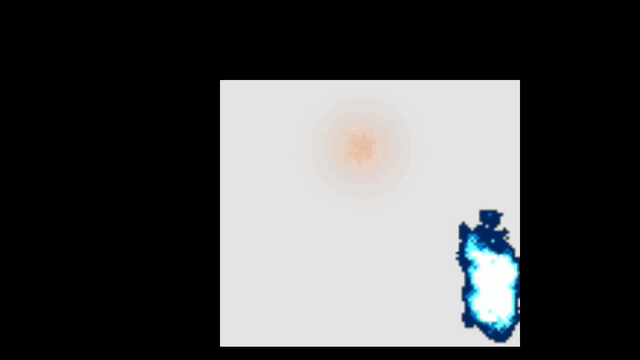